In [1]:
import torch
import pyro
import pyro.distributions as dist
from torch.distributions import constraints
import numpy as np
from pyro.poutine.runtime import _PYRO_PARAM_STORE

In [2]:
# model
def scale(guess):
    weight = pyro.sample("weight", dist.Normal(guess, 1.0))
    return pyro.sample("measurement", dist.Normal(weight, 0.75))


In [3]:
scale(torch.tensor(3.3))

tensor(2.8259)

##### for condition
This function is only looks at the weight satisfying `measurement==9.5`:

In [4]:
# condition0
def conditioned_scale_obs(guess):  # equivalent to conditioned_scale above
    # print("conditioned guess:", guess)
    weight = pyro.sample("weight", dist.Normal(guess, 1.))
     # here we condition on measurement == 9.5
    return pyro.sample("measurement", dist.Normal(weight, 0.75), obs=9.5)

##### for guide
i.e. approximation for weight's posterior distribution `quides = q(z=weight) ~ p(z=weight|x=mesurment)` (will be with use of ELBO):

In [26]:
# guide0
from torch.distributions import constraints

def scale_parametrized_guide(guess):
    
    a = pyro.param("a", torch.tensor(guess))
    b = pyro.param("b", torch.tensor(1.), constraint=constraints.positive)
    print("_PYRO_PARAM_STORE.b.unconstrained:")
    print(_PYRO_PARAM_STORE._params['b'])
    print("_PYRO_PARAM_STORE.b.constrained:")
    print(_PYRO_PARAM_STORE['b']) 
    
    # print("guide a:", a)
    return pyro.sample("weight", dist.Normal(a, torch.abs(b)))

In [27]:
scale_parametrized_guide(torch.tensor(2.2))

_PYRO_PARAM_STORE.b.unconstrained:
tensor(-0.0033, requires_grad=True)
_PYRO_PARAM_STORE.b.constrained:
tensor(0.9967, grad_fn=<AddBackward0>)


/home/valdecar/anaconda3/envs/math/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


tensor(7.4316, grad_fn=<AddBackward0>)

##### for params

In [19]:
print(pyro.get_param_store().keys())

dict_keys(['a', 'b'])


In [20]:
pyro.clear_param_store()

In [21]:
print(pyro.get_param_store().keys())

dict_keys([])


##### for inference
Take such params (`a` and `b`) so they can produce `weight` (using `scale_parametrized_guide`) which satisfy condition (i.e. `conditioned_scale_ops`) (condition used as model). So we knew about `p(x|z)` and will try to find `p(z|x)`:
<br>
${\rm ELBO} \equiv \mathbb{E}_{q_{\phi}({\bf z})} \left [
\log p_{\theta}({\bf x}|{\bf z}) p_{\theta}({\bf z}) - \log q_{\phi}({\bf z})
\right]$

In [24]:
guess = 8.5

pyro.clear_param_store()
svi = pyro.infer.SVI(model=conditioned_scale_obs,
                     guide=scale_parametrized_guide,
                     optim=pyro.optim.SGD({"lr": 0.001, "momentum":0.1}),
                     loss=pyro.infer.Trace_ELBO())


losses, a,b  = [], [], []
num_steps = 4 # 250  # 2500
for t in range(num_steps):
    losses.append(svi.step(guess))
    a.append(pyro.param("a").item())
    b.append(pyro.param("b").item())
    print(pyro.param("b"))

{'a': tensor(8.5000, requires_grad=True), 'b': tensor(0., requires_grad=True)}
tensor(1.0013, grad_fn=<AddBackward0>)
{'a': tensor(8.5011, requires_grad=True), 'b': tensor(0.0013, requires_grad=True)}
tensor(1.0022, grad_fn=<AddBackward0>)
{'a': tensor(8.5009, requires_grad=True), 'b': tensor(0.0022, requires_grad=True)}
tensor(0.9996, grad_fn=<AddBackward0>)
{'a': tensor(8.4984, requires_grad=True), 'b': tensor(-0.0004, requires_grad=True)}
tensor(0.9967, grad_fn=<AddBackward0>)


In [14]:
print(len(a))
print(a[-1])

2
8.500568389892578


##### results:

In [11]:
import matplotlib.pyplot as plt


a =  8.830985069274902
b =  0.72945237159729


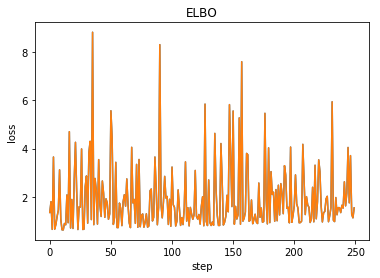

In [13]:
plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss");
print('a = ',pyro.param("a").item())
print('b = ', pyro.param("b").item())
plt.show()

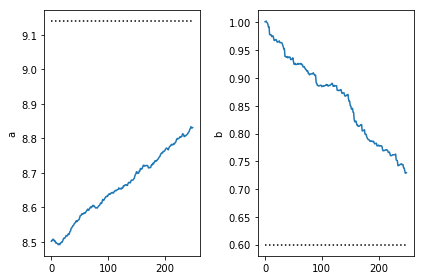

In [14]:
plt.subplot(1,2,1)
plt.plot([0,num_steps],[9.14,9.14], 'k:')
plt.plot(a)
plt.ylabel('a')

plt.subplot(1,2,2)
plt.ylabel('b')
plt.plot([0,num_steps],[0.6,0.6], 'k:')
plt.plot(b)
plt.tight_layout()
plt.show()

In [11]:
data = torch.zeros(10)
data[0:6] = torch.ones(6)


# for vectorized, sampled, independed:
def model13():
    alpha0 = torch.tensor(10.0)
    beta0 = torch.tensor(10.0)

    f = pyro.sample("latent_fairness", dist.Beta(alpha0, beta0)) 

    # vectorized, sampled, independent:
    with pyro.plate("data_loop", size=10, subsample_size=5) as ind:
        dd = dist.Bernoulli(f).expand([5])
        print("dd.batch_shape:")
        print(dd.batch_shape)
        print("dd.event_shape:")
        print(dd.event_shape)
        print("ind:")
        print(ind)
        a = pyro.sample("obs", dd, obs=data.index_select(0, ind))
        print("a:")
        print(a)


In [16]:
model13()

dd.batch_shape:
torch.Size([5])
dd.event_shape:
torch.Size([])
ind:
tensor([3, 7, 5, 9, 6])
a:
tensor([1., 0., 1., 0., 0.])


In [117]:

# for vectorized, sampled, depended:
def model23():
    # alpha0 = torch.tensor(10.0)
    # beta0 = torch.tensor(10.0)
    mu = torch.tensor(0.5)
    sigma = torch.tensor(0.1)

    p = pyro.sample("latent_fairness", dist.Normal(mu, sigma))
    print("p = ", p)
    
    # vectorized, sampled, dependent:
    with pyro.plate("data_loop", size=10, subsample_size=5) as ind:
        # 5 paralel dimentions of size 2 each 
        dd = dist.Bernoulli(p).expand([5, 2]).to_event(1)
        print("dd.batch_shape:")
        print(dd.batch_shape)
        print("dd.event_shape:")
        print(dd.event_shape)
        x = dd.sample()
        print("x = ", x)
        # dd will use Bernoulli with is accurate to!
        print("prob(x) = ", torch.exp(dd.log_prob(x)))
        print("accurate: ",
              torch.tensor([(p if x0 else 1-p)*(p if x1 else 1-p)
                            for x0, x1 in x]))
        
        print("ind:")
        print(ind)
        a = pyro.sample("obs", dd, obs=data.index_select(0, ind))
        print("a:")
        print(a)


In [118]:
model23()

p =  tensor(0.5121)
dd.batch_shape:
torch.Size([5])
dd.event_shape:
torch.Size([2])
x =  tensor([[0., 0.],
        [1., 0.],
        [0., 1.],
        [1., 1.],
        [1., 0.]])
prob(x) =  tensor([0.2380, 0.2499, 0.2499, 0.2623, 0.2499])
accurate:  tensor([0.2380, 0.2499, 0.2499, 0.2623, 0.2499])
ind:
tensor([6, 2, 9, 8, 0])
a:
tensor([0., 1., 0., 0., 1.])


##### for 
conditionaly depended:

In [14]:
# Bernulli:
p = 0.7
dd = dist.Bernoulli(p*torch.ones((3,2))).to_event(2)
x = dd.sample()
print("x = ", x)
print("prob(x) = ", torch.exp(dd.log_prob(x)))
print("accurate: ", torch.tensor([(p if x0 else 1-p)*(p if x1 else 1-p)
                                  for x0, x1 in x]))

x =  tensor([[1., 0.],
        [1., 0.],
        [1., 1.]])
prob(x) =  tensor(0.0216)
accurate:  tensor([0.2100, 0.2100, 0.4900])


so experiment is of droping two dices five times

In [95]:
# Normal:
dd = dist.Normal(0.0*torch.ones((3,2)),
                 1.0*torch.ones((3,2))).to_event(1)
x = dd.sample()
print("x = ", x)
print("prob(x) = ", torch.exp(dd.log_prob(x)))

f = lambda x: 1/np.sqrt(2*np.pi) * np.exp(-0.5*np.power(x,2))
print("accurate: ", torch.tensor([f(x0)*f(x1) for x0, x1 in x]))

x =  tensor([[-1.0040, -0.5045],
        [-1.2116, -0.4331],
        [-0.5154,  1.5380]])
prob(x) =  tensor([0.0847, 0.0696, 0.0427])
accurate:  tensor([0.0847, 0.0696, 0.0427], dtype=torch.float64)


In [78]:
# dd.to_event??
# isinstance(dd, torch.distributions.Independent)
# torch.distributions.Independent?

##### for 
`rand`

In [37]:
torch.rand((3,2))

tensor([[0.7280, 0.2271],
        [0.5586, 0.0519],
        [0.9976, 0.1992]])

##### for 
`dist.log_prob`

In [61]:
d = torch.distributions.Normal(torch.tensor([0.0]),
                               torch.tensor([1.0]))

In [64]:
f = lambda x: 1/np.sqrt(2*np.pi) * np.exp(-0.5*np.power(x,2))

In [66]:
print("accurate: ", f(0))
print("pyros: ", torch.exp(d.log_prob(0.0)))

accurate:  0.3989422804014327
pyros:  tensor([0.3989])


In [75]:
d = torch.distributions.Bernoulli(0.7)
print(torch.exp(d.log_prob(0)))

tensor(0.3000)


##### for 
`plate`

In [10]:
x_axis = pyro.plate("x", 3, dim=-1)
y_axis = pyro.plate("y", 2, dim=-2)
with x_axis:
    x = pyro.sample("x", dist.Normal(0, 1))
with y_axis:
    y = pyro.sample("y", dist.Normal(0, 1))
print("x.shape:", x.shape)
print("x: ", x)
print("y.shape: ", y.shape)
print("y: ", y)

x.shape: torch.Size([3])
x:  tensor([-0.0522, -0.0631,  0.0150])
y.shape:  torch.Size([2, 1])
y:  tensor([[-1.0739],
        [-1.0456]])


In [22]:
import pyro.distributions as pdist


with pyro.poutine.trace_messenger.TraceMessenger() as tm:
    with pyro.plate("p1",size=5,dim=-2):
        x = pyro.sample("x", pdist.Bernoulli(0.3).expand([5,2]).to_event(0))
        print(x.shape)

torch.Size([5, 2])


In [25]:
# for compute model factors:
tm.trace.symbolize_dims() 
print(tm.trace.plate_to_symbol)
l = [(name, site) for name, site in tm.trace.nodes.items()] 
d = dict(l)
print(d["x"]["cond_indep_stack"][0].vectorized)
print(tm.trace.plate_to_symbol[d["x"]["cond_indep_stack"][0].name])

{'p1': 'a'}
True
a


In [20]:
trace = pyro.poutine.trace(model)

In [4]:
import itertools
# test pack:
EXAMPLE_DIMS = [
    "".join(dims)
    for num_dims in range(5)
    for dims in itertools.permutations("abcd"[:num_dims])
]
print(EXAMPLE_DIMS)

['', 'a', 'ab', 'ba', 'abc', 'acb', 'bac', 'bca', 'cab', 'cba', 'abcd', 'abdc', 'acbd', 'acdb', 'adbc', 'adcb', 'bacd', 'badc', 'bcad', 'bcda', 'bdac', 'bdca', 'cabd', 'cadb', 'cbad', 'cbda', 'cdab', 'cdba', 'dabc', 'dacb', 'dbac', 'dbca', 'dcab', 'dcba']


In [15]:
import torch
from pyro.ops import packed

dims = EXAMPLE_DIMS[14]
dim_to_symbol = {}
symbol_to_dim = {}
for symbol, dim in zip("abcd", range(-1, -5, -1)):
    dim_to_symbol[dim] = symbol
    symbol_to_dim[symbol] = dim
shape = tuple(range(2, 2 + len(dims)))
x = torch.randn(shape)

pack_x = packed.pack(x, dim_to_symbol)
unpack_pack_x = packed.unpack(pack_x, symbol_to_dim)

In [14]:
dim_to_symbol

{-4: 'd', -3: 'c', -2: 'b', -1: 'a'}

In [19]:
x.shape

torch.Size([2, 3, 4, 5])

In [18]:
pack_x.shape

torch.Size([2, 3, 4, 5])

In [ ]:
trace.sy

In [2]:
# enumeration
import torch
import pyro
import pyro.distributions as dist
from pyro.infer.autoguide import AutoNormal
from pyro import poutine
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO, config_enumerate, infer_discrete
from pyro.optim import Adam

In [3]:
data_dim = 4
num_steps = 10
hidden_dim = 10
data = dist.Categorical(torch.ones(num_steps, data_dim)).sample()

def pyro_iter(data, markov):
    if markov:
        return pyro.markov(enumerate(data))
    else:
        return enumerate(data)
    
def hmm_model(data, data_dim, hidden_dim=10, markov=False):
    print(f"Running for {len(data)} time steps")
    # Sample global matrices wrt a Jeffreys prior.
    with pyro.plate("hidden_state", hidden_dim):
        transition = pyro.sample("transition", dist.Dirichlet(0.5 * torch.ones(hidden_dim)))
        emission = pyro.sample("emission", dist.Dirichlet(0.5 * torch.ones(data_dim)))

    x = 0  # initial state
    zs = []
    # for t, y in enumerate(data):
    # for t, y in pyro.markov(enumerate(data)):
    for t, y in pyro_iter(data, markov):
        x = pyro.sample(f"x_{t}", dist.Categorical(transition[x]),
                        infer={"enumerate": "parallel"})
        if y is not None:
            z = pyro.sample(f"  y_{t}", dist.Categorical(emission[x]), obs=y)
        else:
            z = pyro.sample(f"  y_{t}", dist.Categorical(emission[x]))
        zs.append(z)
        print(f"  x_{t}.shape = {x.shape}")
    return zs

In [3]:
hmm_model(data, data_dim)

Running for 10 time steps
  x_0.shape = torch.Size([])
  x_1.shape = torch.Size([])
  x_2.shape = torch.Size([])
  x_3.shape = torch.Size([])
  x_4.shape = torch.Size([])
  x_5.shape = torch.Size([])
  x_6.shape = torch.Size([])
  x_7.shape = torch.Size([])
  x_8.shape = torch.Size([])
  x_9.shape = torch.Size([])


/home/valdecar/anaconda3/envs/math/lib/python3.6/site-packages/pyro/primitives.py:86: RuntimeWarning: trying to observe a value outside of inference at   y_0
  RuntimeWarning)
/home/valdecar/anaconda3/envs/math/lib/python3.6/site-packages/pyro/primitives.py:86: RuntimeWarning: trying to observe a value outside of inference at   y_1
  RuntimeWarning)
/home/valdecar/anaconda3/envs/math/lib/python3.6/site-packages/pyro/primitives.py:86: RuntimeWarning: trying to observe a value outside of inference at   y_2
  RuntimeWarning)
/home/valdecar/anaconda3/envs/math/lib/python3.6/site-packages/pyro/primitives.py:86: RuntimeWarning: trying to observe a value outside of inference at   y_3
  RuntimeWarning)
/home/valdecar/anaconda3/envs/math/lib/python3.6/site-packages/pyro/primitives.py:86: RuntimeWarning: trying to observe a value outside of inference at   y_4
  RuntimeWarning)
/home/valdecar/anaconda3/envs/math/lib/python3.6/site-packages/pyro/primitives.py:86: RuntimeWarning: trying to observe 

[tensor(2),
 tensor(2),
 tensor(3),
 tensor(1),
 tensor(2),
 tensor(3),
 tensor(0),
 tensor(1),
 tensor(1),
 tensor(1)]

In [4]:
# hmm_model(data, data_dim)
pyro.clear_param_store()
hmm_guide = AutoNormal(poutine.block(
        hmm_model, expose=["transition", "emission"]))

see also `test_pyro hierarchy`

with `enumeration`:

In [5]:
elbo = TraceEnum_ELBO(max_plate_nesting=1)
svi = SVI(hmm_model, hmm_guide, Adam({'lr': 1e-3}), elbo)
loss = svi.step(data, data_dim, hidden_dim, markov=False)  
# loss = svi.step(obs_ys, obs_transition, data_dim, hidden_dim)  

Running for 10 time steps
  x_0.shape = torch.Size([])
  x_1.shape = torch.Size([])
  x_2.shape = torch.Size([])
  x_3.shape = torch.Size([])
  x_4.shape = torch.Size([])
  x_5.shape = torch.Size([])
  x_6.shape = torch.Size([])
  x_7.shape = torch.Size([])
  x_8.shape = torch.Size([])
  x_9.shape = torch.Size([])
Running for 10 time steps
  x_0.shape = torch.Size([10, 1])
  x_1.shape = torch.Size([10, 1, 1])
  x_2.shape = torch.Size([10, 1, 1, 1])
  x_3.shape = torch.Size([10, 1, 1, 1, 1])
  x_4.shape = torch.Size([10, 1, 1, 1, 1, 1])
  x_5.shape = torch.Size([10, 1, 1, 1, 1, 1, 1])
  x_6.shape = torch.Size([10, 1, 1, 1, 1, 1, 1, 1])
  x_7.shape = torch.Size([10, 1, 1, 1, 1, 1, 1, 1, 1])
  x_8.shape = torch.Size([10, 1, 1, 1, 1, 1, 1, 1, 1, 1])
  x_9.shape = torch.Size([10, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])


/home/valdecar/anaconda3/envs/math/lib/python3.6/site-packages/torch/autograd/__init__.py:132: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 8000). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachable flag


In [8]:
loss

306.8924255371094

with `markov`

In [39]:
loss = svi.step(data, data_dim, hidden_dim, markov=True)

Running for 10 time steps
  x_0.shape = torch.Size([10, 1])
  x_1.shape = torch.Size([10, 1, 1])
  x_2.shape = torch.Size([10, 1])
  x_3.shape = torch.Size([10, 1, 1])
  x_4.shape = torch.Size([10, 1])
  x_5.shape = torch.Size([10, 1, 1])
  x_6.shape = torch.Size([10, 1])
  x_7.shape = torch.Size([10, 1, 1])
  x_8.shape = torch.Size([10, 1])
  x_9.shape = torch.Size([10, 1, 1])


In [10]:
from pyro.infer.autoguide import AutoDelta

data = torch.tensor([0., 1., 10., 11., 12.])

K = 2  # Fixed number of components.

@config_enumerate
def model(data):
    # Global variables.
    weights = pyro.sample('weights', dist.Dirichlet(0.5 * torch.ones(K)))
    scale = pyro.sample('scale', dist.LogNormal(0., 2.))
    with pyro.plate('components', K):
        locs = pyro.sample('locs', dist.Normal(0., 10.))
    print("locs:", locs)
    print("weights:", weights)
    
    with pyro.plate('data', len(data)):
        # Local variables.
        assignment = pyro.sample('assignment', dist.Categorical(weights))
        pyro.sample('obs', dist.Normal(locs[assignment], scale), obs=data)
    print("assignment:", assignment)
    
elbo = TraceEnum_ELBO(max_plate_nesting=1)
guide = AutoDelta(poutine.block(model, expose=['weights', 'locs', 'scale'])) # , init_loc_fn=init_loc_fn)
optim = pyro.optim.Adam({'lr': 0.1, 'betas': [0.8, 0.99]})
svi = SVI(model, guide, optim, loss=elbo)
svi.loss(model, guide, data)

locs: tensor([-0.9139, -3.1421])
weights: tensor([0.5000, 0.5000])
assignment: tensor([0, 1, 1, 1, 1])
locs: tensor([-3.2609,  0.5703], grad_fn=<ExpandBackward>)
weights: tensor([0.5000, 0.5000], grad_fn=<ExpandBackward>)
assignment: tensor([[0],
        [1]])


254.09886169433594

### For max_plate nesting
(REF: http://pyro.ai/examples/enumeration.html#Mechanics-of-enumeration)

In [6]:
def model():
    z = pyro.sample("z", dist.Categorical(torch.ones(5)))
    print(f"model z = {z}")

def guide():
    z = pyro.sample("z", dist.Categorical(torch.ones(5)))
    print(f"guide z = {z}")

elbo = Trace_ELBO()
elbo.loss(model, guide);

guide z = 1
model z = 1


In [15]:
elbo = TraceEnum_ELBO(max_plate_nesting=0)
elbo.loss(model, config_enumerate(guide, "parallel"));

guide z = tensor([0, 1, 2, 3, 4])
model z = tensor([0, 1, 2, 3, 4])
